In [1]:
!pip install pydotplus
!pip install graphviz

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import nltk
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')
df.drop(['id'], axis=1, inplace=True)
df.head()

,tweets,labels
0,aaj ka khel khatam hone k baad england cricket...,0
1,purana manjan bech rha hai,5
2,tumhare disappointed se kuch ni hoga,0
3,inse bas tiktok banva lo batting ni hoti isse ...,3
4,bhai cricket par tweets mat kara karo please j...,3


# Labels are as follows:
0 - No emotions,
1 - Happy,
2 - Sad,
3 - Angry,
4 - Fear,
5 - Disgust,
6 - Surprise

In [4]:
print("Dataset shape: ", df.shape)
df['labels'].value_counts()

Dataset shape:  (9165, 2)


0    1892
3    1763
2    1529
1    1226
5    1147
6    1049
4     559
Name: labels, dtype: int64

### Plotting Word Cloud:

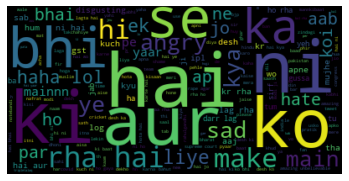

In [5]:
common_words=''
for i in df.tweets:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# 1. Model without removing any feature:

### Vectorizing tweets by converting each tweets into a Vector

In [6]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22420 unique tokens.


### Padding input sequence to make shape and size each tweets equal

In [7]:
X = tokenizer.texts_to_sequences(df['tweets'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9165, 250)


### Transforming Dataset using TF-IDF Vectorizer

In [8]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(df['tweets'])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
df['tweets'] = vectoriser.transform(df['tweets'])

No. of feature_words:  137046


### Creating dummy variables for labels

In [9]:
y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (9165, 7)


### Splitting data into Train and Test sets

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7332, 250) (7332, 7)
(1833, 250) (1833, 7)


### Creating Base Model:

In [11]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])) # The first layer is the embedded layer that uses 100 length vectors to represent each word
model.add(SpatialDropout1D(0.4))  # SpatialDropout1D performs variational dropout in NLP models
model.add(LSTM(250, dropout=0.2, return_sequences=True,recurrent_dropout=0,activation='tanh',recurrent_activation = 'sigmoid',use_bias=True,unroll=False)) # This layer is the LSTM layer with 250 memory units.
model.add(LSTM(250, dropout=0.2, recurrent_dropout=0)) # This layer is the LSTM layer with 250 memory units.
model.add(Dense(7, activation='softmax')) # The output layer with 7 output values, one for each class. Activation function is softmax for multi-class classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # This multi-class classification problem, categorical_crossentropy is used as the loss function

epochs = 2
batch_size = 64

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 250, 250)          351000    
                                                                 
 lstm_1 (LSTM)               (None, 250)               501000    
                                                                 
 dense (Dense)               (None, 7)                 1757      
                                                                 
Total params: 5,853,757
Trainable params: 5,853,757
Non-trainable params: 0
______________________________________________

### Plotting LSTM Model

In [12]:
plot_model(model, show_shapes=True, show_layer_names=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [13]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

Epoch 1/2
104/104 [==============================] - 11s 71ms/step - loss: 1.5084 - accuracy: 0.4127 - val_loss: 1.0177 - val_accuracy: 0.6308
Epoch 2/2
58/58 [==============================] - 1s 24ms/step - loss: 0.7985 - accuracy: 0.7223
Test set
  Loss: 0.7985
  Accuracy: 0.7223


### Plotting Accuracy & Loss

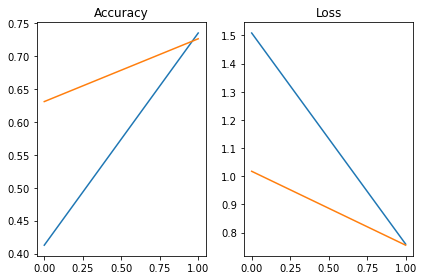

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title('Accuracy')
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='validation')

axes[1].set_title('Loss')
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='validation')
plt.tight_layout()

### Confusion Matrix:

In [15]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[296  10  15  14   7   3  16]
 [ 23 185  14  11   2   0   7]
 [ 33  31 217  15   7   3   4]
 [ 48  15  17 235   7  14  10]
 [ 12   2   6   3  79   0   2]
 [ 29   3  16  14  22 155   0]
 [ 37  12  11   9   4   1 157]]
              precision    recall  f1-score   support

           0       0.62      0.82      0.71       361
           1       0.72      0.76      0.74       242
           2       0.73      0.70      0.72       310
           3       0.78      0.68      0.73       346
           4       0.62      0.76      0.68       104
           5       0.88      0.65      0.75       239
           6       0.80      0.68      0.74       231

    accuracy                           0.72      1833
   macro avg       0.74      0.72      0.72      1833
weighted avg       0.74      0.72      0.72      1833



# 2. Model after removing stopwords:

In [16]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')

### Removing Stopwords:

In [17]:
# Using Hinglish stopwords which contains 1036 words from both English and Hindi languages
# Source: https://github.com/TrigonaMinima/HinglishNLP/blob/master/data/assets/stop_hinglish

stopwordlist = ['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa', 'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna', 'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as', 'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut', 'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane', 'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola', 'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye', 'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could', 'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe', 'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya', 'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono', 'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during', 'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight', 'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few', 'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four', 'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari', 'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven', 'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself', 'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge', 'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however', 'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye', 'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe', 'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into', 'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt', "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno', 'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha', 'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi', 'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski', 'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka', 'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte', 'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen', 'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu', 'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh', 'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko', 'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne', 'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon', 'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu', 'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least', 'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little', 'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga', 'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly', 'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein', 'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe', 'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't", 'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near', 'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps', 'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri', 'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi', 'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte', 'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi', 'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath', 'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt', "shouldn't", "should've", 'si', 'since', 'six', 'so', 'soch', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah', 'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th', 'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi', 'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru', 'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune', 'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa', 'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss', 'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa', 'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala', 'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin', 'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt', "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent', "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing', 'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn', 'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye', 'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'yup']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweets'] = df['tweets'].apply(lambda text: cleaning_stopwords(text))

### Vectorizing tweets by converting each tweets into a Vector

In [18]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21797 unique tokens.


### Padding input sequence to make shape and size each tweets equal

In [19]:
X = tokenizer.texts_to_sequences(df['tweets'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9165, 250)


### Transforming Dataset using TF-IDF Vectorizer

In [20]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(df['tweets'])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
df['tweets'] = vectoriser.transform(df['tweets'])

No. of feature_words:  99971


### Creating dummy variables for labels

In [21]:
y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (9165, 7)


### Splitting data into Train and Test sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7332, 250) (7332, 7)
(1833, 250) (1833, 7)


### Training Model:

In [23]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

Epoch 1/2
104/104 [==============================] - 7s 63ms/step - loss: 1.3842 - accuracy: 0.5085 - val_loss: 0.9284 - val_accuracy: 0.6567
Epoch 2/2
58/58 [==============================] - 1s 22ms/step - loss: 0.9038 - accuracy: 0.6934
Test set
  Loss: 0.9038
  Accuracy: 0.6934


### Plotting Accuracy & Loss

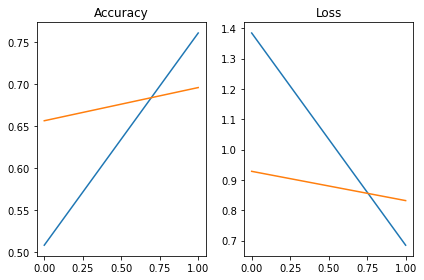

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title('Accuracy')
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='validation')

axes[1].set_title('Loss')
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='validation')
plt.tight_layout()

### Confusion Matrix:

In [25]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[294  17  18  12   2  16   2]
 [ 31 176  22  10   0   0   3]
 [ 45  21 218  19   1   5   1]
 [ 52  19  32 227   0  14   2]
 [ 13   7   7   6  63   6   2]
 [ 35  10  16   6   2 169   1]
 [ 55  26  12   9   3   2 124]]
              precision    recall  f1-score   support

           0       0.56      0.81      0.66       361
           1       0.64      0.73      0.68       242
           2       0.67      0.70      0.69       310
           3       0.79      0.66      0.71       346
           4       0.89      0.61      0.72       104
           5       0.80      0.71      0.75       239
           6       0.92      0.54      0.68       231

    accuracy                           0.69      1833
   macro avg       0.75      0.68      0.70      1833
weighted avg       0.73      0.69      0.70      1833



# 3. Model after removing repeating characters:

In [26]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')

### Removing repeating characteres:

In [27]:
tokens = (word_tokenize(i) for i in df.tweets)
df['tweets'] = df['tweets'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.tweets = df.tweets.apply(lambda tweet: reduce_sequence_tweet(tweet))

def detokenizing(text):
    itertools.chain(text)
    return text

df['tweets'] = df['tweets'].apply(lambda x: detokenizing(x))

### Vectorizing tweets by converting each tweets into a Vector

In [28]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22287 unique tokens.


### Padding input sequence to make shape and size each tweets equal

In [29]:
X = tokenizer.texts_to_sequences(df['tweets'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9165, 250)


### Transforming Dataset using TF-IDF Vectorizer

In [30]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
df['tweets'] = df['tweets'].astype(str)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(df['tweets'])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
df['tweets'] = vectoriser.transform(df['tweets'])

No. of feature_words:  136884


### Creating dummy variables for labels

In [31]:
y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (9165, 7)


### Splitting data into Train and Test sets

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7332, 250) (7332, 7)
(1833, 250) (1833, 7)


### Training Model:

In [33]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

Epoch 1/2
104/104 [==============================] - 7s 67ms/step - loss: 1.1944 - accuracy: 0.5702 - val_loss: 0.9122 - val_accuracy: 0.6567
Epoch 2/2
58/58 [==============================] - 1s 22ms/step - loss: 0.8848 - accuracy: 0.6819
Test set
  Loss: 0.8848
  Accuracy: 0.6819


### Plotting Accuracy & Loss

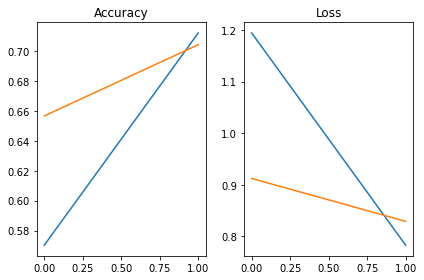

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title('Accuracy')
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='validation')

axes[1].set_title('Loss')
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='validation')
plt.tight_layout()

### Confusion Matrix:

In [35]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[309  11   9   9   7  10   6]
 [ 58 167   6   3   3   1   4]
 [ 63  23 200  15   3   5   1]
 [ 96  18   7 209   4   7   5]
 [ 19   3   2   2  73   3   2]
 [ 51   8  10   5   3 161   1]
 [ 68  18   3   6   5   0 131]]
              precision    recall  f1-score   support

           0       0.47      0.86      0.60       361
           1       0.67      0.69      0.68       242
           2       0.84      0.65      0.73       310
           3       0.84      0.60      0.70       346
           4       0.74      0.70      0.72       104
           5       0.86      0.67      0.76       239
           6       0.87      0.57      0.69       231

    accuracy                           0.68      1833
   macro avg       0.76      0.68      0.70      1833
weighted avg       0.75      0.68      0.69      1833



# 4. Model after removing Punctuations:

In [36]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')

### Removing Punctuations:

In [37]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['tweets'] = df['tweets'].apply(lambda x: cleaning_punctuations(x))

### Vectorizing tweets by converting each tweets into a Vector

In [39]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22386 unique tokens.


### Padding input sequence to make shape and size each tweets equal

In [40]:
X = tokenizer.texts_to_sequences(df['tweets'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9165, 250)


### Transforming Dataset using TF-IDF Vectorizer

In [41]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(df['tweets'])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
df['tweets'] = vectoriser.transform(df['tweets'])

No. of feature_words:  137125


### Creating dummy variables for labels

In [42]:
y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (9165, 7)


### Splitting data into Train and Test sets

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7332, 250) (7332, 7)
(1833, 250) (1833, 7)


### Training Model:

In [44]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

Epoch 1/2
104/104 [==============================] - 7s 67ms/step - loss: 0.9462 - accuracy: 0.6640 - val_loss: 0.8234 - val_accuracy: 0.7003
Epoch 2/2
58/58 [==============================] - 1s 22ms/step - loss: 0.8095 - accuracy: 0.7136
Test set
  Loss: 0.8095
  Accuracy: 0.7136


### Plotting Accuracy & Loss

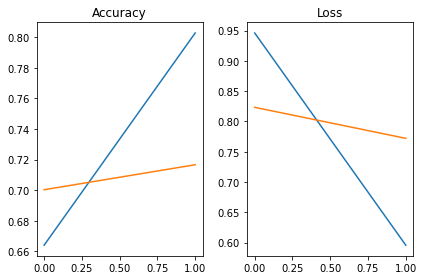

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title('Accuracy')
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='validation')

axes[1].set_title('Loss')
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='validation')
plt.tight_layout()

### Confusion Matrix:

In [46]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[292  11   5  24   4   4  21]
 [ 31 168  13  12   2   3  13]
 [ 48  22 199  31   1   2   7]
 [ 56  11  18 245   1   8   7]
 [ 15   6   1   3  77   1   1]
 [ 21  10   7  22   5 172   2]
 [ 44  10   4  12   4   2 155]]
              precision    recall  f1-score   support

           0       0.58      0.81      0.67       361
           1       0.71      0.69      0.70       242
           2       0.81      0.64      0.71       310
           3       0.70      0.71      0.71       346
           4       0.82      0.74      0.78       104
           5       0.90      0.72      0.80       239
           6       0.75      0.67      0.71       231

    accuracy                           0.71      1833
   macro avg       0.75      0.71      0.73      1833
weighted avg       0.73      0.71      0.72      1833



# 5. Model after removing numbers:

In [47]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')

### Removing numbers:

In [48]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['tweets'] = df['tweets'].apply(lambda text: cleaning_numbers(text))

### Vectorizing tweets by converting each tweets into a Vector

In [49]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 22038 unique tokens.


### Padding input sequence to make shape and size each tweets equal

In [50]:
X = tokenizer.texts_to_sequences(df['tweets'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9165, 250)


### Transforming Dataset using TF-IDF Vectorizer

In [51]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(df['tweets'])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
df['tweets'] = vectoriser.transform(df['tweets'])

No. of feature_words:  135776


### Creating dummy variables for labels

In [52]:
y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (9165, 7)


### Splitting data into Train and Test sets

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7332, 250) (7332, 7)
(1833, 250) (1833, 7)


### Training Model:

In [54]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

Epoch 1/2
104/104 [==============================] - 7s 69ms/step - loss: 0.8280 - accuracy: 0.7079 - val_loss: 0.9280 - val_accuracy: 0.6580
Epoch 2/2
58/58 [==============================] - 1s 23ms/step - loss: 0.7728 - accuracy: 0.7305
Test set
  Loss: 0.7728
  Accuracy: 0.7305


### Plotting Accuracy & Loss

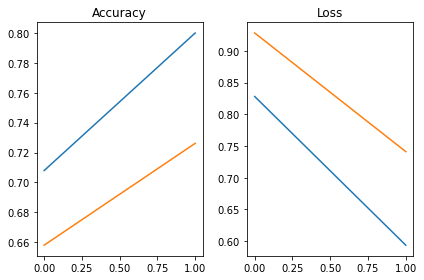

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title('Accuracy')
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='validation')

axes[1].set_title('Loss')
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='validation')
plt.tight_layout()

### Confusion Matrix:

In [56]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[286   9  11  34   3   7  11]
 [ 20 167  22  23   0   2   8]
 [ 29  20 216  34   2   3   6]
 [ 43   5  17 259   0  18   4]
 [ 10   5   4   4  76   3   2]
 [ 24   1   7  27   2 178   0]
 [ 29   7   7  23   4   4 157]]
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       361
           1       0.78      0.69      0.73       242
           2       0.76      0.70      0.73       310
           3       0.64      0.75      0.69       346
           4       0.87      0.73      0.80       104
           5       0.83      0.74      0.78       239
           6       0.84      0.68      0.75       231

    accuracy                           0.73      1833
   macro avg       0.77      0.73      0.74      1833
weighted avg       0.74      0.73      0.73      1833



# 6. Model after removing all the features:

In [57]:
df = pd.read_excel('Code Mixed Hindi-English tweets.xlsx')

### Removing Punctuations:

In [58]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [59]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['tweets'] = df['tweets'].apply(lambda x: cleaning_punctuations(x))

### Removing Stopwords:

In [60]:
# Using Hinglish stopwords which contains 1036 words from both English and Hindi languages
# Source: https://github.com/TrigonaMinima/HinglishNLP/blob/master/data/assets/stop_hinglish

stopwordlist = ['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa', 'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna', 'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as', 'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut', 'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane', 'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola', 'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye', 'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could', 'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe', 'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya', 'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono', 'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during', 'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight', 'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few', 'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four', 'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari', 'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven', 'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself', 'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge', 'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however', 'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye', 'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe', 'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into', 'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt', "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno', 'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha', 'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi', 'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski', 'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka', 'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte', 'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen', 'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu', 'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh', 'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko', 'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne', 'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon', 'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu', 'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least', 'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little', 'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga', 'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly', 'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein', 'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe', 'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't", 'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near', 'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps', 'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri', 'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi', 'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte', 'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi', 'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath', 'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt', "shouldn't", "should've", 'si', 'since', 'six', 'so', 'soch', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah', 'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th', 'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi', 'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru', 'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune', 'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa', 'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss', 'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa', 'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala', 'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin', 'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt', "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent', "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing', 'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn', 'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye', 'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'yup']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweets'] = df['tweets'].apply(lambda text: cleaning_stopwords(text))

### Removing Numbers:

In [61]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['tweets'] = df['tweets'].apply(lambda text: cleaning_numbers(text))

### Removing repeating characters:

In [62]:
tokens = (word_tokenize(i) for i in df.tweets)
df['tweets'] = df['tweets'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.tweets = df.tweets.apply(lambda tweet: reduce_sequence_tweet(tweet))

def detokenizing(text):
    itertools.chain(text)
    return text

df['tweets'] = df['tweets'].apply(lambda x: detokenizing(x))

### Vectorizing tweets by converting each tweets into a Vector

In [63]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each tweet.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweets'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 21212 unique tokens.


### Padding input sequence to make shape and size each tweets equal

In [64]:
X = tokenizer.texts_to_sequences(df['tweets'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (9165, 250)


### Transforming Dataset using TF-IDF Vectorizer

In [65]:
# Extracting features using TF-IDF (1,2) - unigrams and bigrams
df['tweets'] = df['tweets'].astype(str)
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(df['tweets'])
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

# Transforming the data using TD-IDF Vectorizer
df['tweets'] = vectoriser.transform(df['tweets'])

No. of feature_words:  98329


### Creating dummy variables for labels

In [66]:
y = pd.get_dummies(df['labels']).values
print('Shape of label tensor:', y.shape)

Shape of label tensor: (9165, 7)


### Splitting data into Train and Test sets

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 3)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(7332, 250) (7332, 7)
(1833, 250) (1833, 7)


### Training Model:

In [68]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(accr[0],accr[1]))

Epoch 1/2
104/104 [==============================] - 16s 150ms/step - loss: 1.1229 - accuracy: 0.6018 - val_loss: 0.9197 - val_accuracy: 0.6730
Epoch 2/2
58/58 [==============================] - 7s 122ms/step - loss: 0.9066 - accuracy: 0.6918
Test set
  Loss: 0.9066
  Accuracy: 0.6918


### Plotting Accuracy & Loss

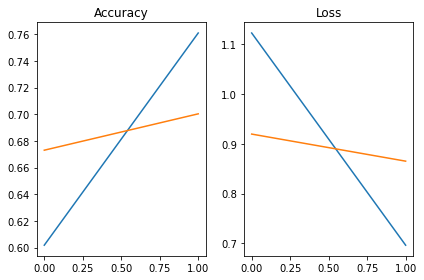

In [69]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].set_title('Accuracy')
axes[0].plot(history.history['accuracy'], label='train')
axes[0].plot(history.history['val_accuracy'], label='validation')

axes[1].set_title('Loss')
axes[1].plot(history.history['loss'], label='train')
axes[1].plot(history.history['val_loss'], label='validation')
plt.tight_layout()

### Confusion Matrix:

In [70]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[269   8  21  36   3  10  14]
 [ 28 158  15  19   2  10  10]
 [ 36  14 215  26   1  14   4]
 [ 35  11  15 251   2  28   4]
 [  9   3   8   9  68   5   2]
 [ 25   4  11  23   4 171   1]
 [ 45   9   8  21   4   8 136]]
              precision    recall  f1-score   support

           0       0.60      0.75      0.67       361
           1       0.76      0.65      0.70       242
           2       0.73      0.69      0.71       310
           3       0.65      0.73      0.69       346
           4       0.81      0.65      0.72       104
           5       0.70      0.72      0.71       239
           6       0.80      0.59      0.68       231

    accuracy                           0.69      1833
   macro avg       0.72      0.68      0.70      1833
weighted avg       0.70      0.69      0.69      1833

